In [1]:
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.dagcircuit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
import supremacy_generator as suprem_gen
from qiskit import *
from qiskit.visualization import plot_state_city
import numpy as np
import functools
import timeit
from datetime import timedelta
import supremacy_generator as suprem_gen
import matplotlib.pyplot as plt
from matplotlib import cm

dimensions = range(1,6)
num_qubits = [x*x for x in dimensions]
sv_times = np.zeros((len(dimensions), len(dimensions)))
qasm_times = np.zeros((len(dimensions), len(dimensions)))
difference = np.zeros((len(dimensions), len(dimensions)))

for i in dimensions:
    for j in dimensions:
        if i*j<=24:
            circ = suprem_gen.circuit_generator(circuit_dimension=[i,j,8])

            sv_start = timeit.default_timer()
            backend = BasicAer.get_backend('statevector_simulator')
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ)
            sv_outputprob = [np.power(abs(x),2) for x in outputstate]
            sv_end = timeit.default_timer()
            sv_times[i-1,j-1] = sv_end-sv_start

            qasm_start = timeit.default_timer()
            num_measurements = int(np.power(2,i*j))
            c = ClassicalRegister(i*j, 'c')
            meas = QuantumCircuit(circ.qregs[0], c)
            meas.barrier(circ.qubits)
            meas.measure(circ.qubits,c)
            qc = circ+meas

            backend_sim = BasicAer.get_backend('qasm_simulator')
            job_sim = execute(qc, backend_sim, shots=num_measurements)
            result_sim = job_sim.result()
            counts = result_sim.get_counts(qc)
            qasm_outputprob = [counts[x]/num_measurements for x in counts]
            qasm_end = timeit.default_timer()
            qasm_times[i-1,j-1] = qasm_end-qasm_start
            difference[i-1,j-1] = sv_times[i-1,j-1] - qasm_times[i-1,j-1]
        else:
            sv_times[i-1,j-1] = 0
            qasm_times[i-1,j-1] = 0
            difference[i-1,j-1] = sv_times[i-1,j-1] - qasm_times[i-1,j-1]

print('sv_times:\n', sv_times)
print('qasm_times:\n', qasm_times)
print('sv - qasm:\n', difference)

sv_times:
 [[ 0.01839958  0.01903307  0.0245235   0.02965229  0.03700497]
 [ 0.0199181   0.03560012  0.05166817  0.06851727  0.0874935 ]
 [ 0.02659748  0.05112826  0.08337753  0.19987616  0.5048915 ]
 [ 0.02925465  0.06334775  0.15194216  0.87755226 12.4056916 ]
 [ 0.06959954  0.09523587  0.48134197 12.55060777  0.        ]]
qasm_times:
 [[1.64791460e-02 2.10104740e-02 2.85483340e-02 3.56063550e-02
  4.19066920e-02]
 [2.24960940e-02 4.11220430e-02 6.08752790e-02 7.82700900e-02
  1.11244531e-01]
 [2.90774560e-02 5.96115390e-02 9.52895890e-02 1.88205899e-01
  1.03499020e+00]
 [3.38185710e-02 7.63316270e-02 2.08061697e-01 1.70297581e+00
  2.99005791e+01]
 [8.94150780e-02 1.28327050e-01 9.36435072e-01 3.01881467e+01
  0.00000000e+00]]
sv - qasm:
 [[ 1.92043100e-03 -1.97740000e-03 -4.02483000e-03 -5.95406100e-03
  -4.90172200e-03]
 [-2.57799700e-03 -5.52192200e-03 -9.20710500e-03 -9.75281800e-03
  -2.37510300e-02]
 [-2.47997700e-03 -8.48328400e-03 -1.19120610e-02  1.16702560e-02
  -5.300987

<Figure size 1000x1000 with 6 Axes>

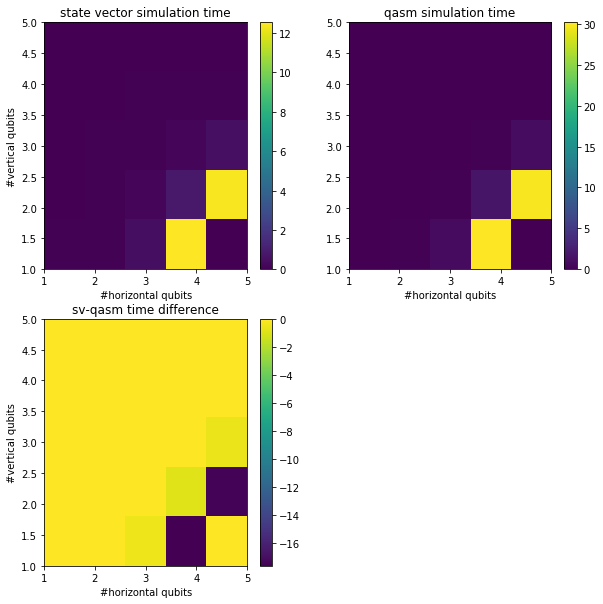

In [2]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(sv_times, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.xlabel('#horizontal qubits')
plt.ylabel('#vertical qubits')
plt.title('state vector simulation time')
plt.colorbar()
plt.subplot(222)
plt.imshow(qasm_times, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.colorbar()
plt.xlabel('#horizontal qubits')
plt.title('qasm simulation time')
plt.subplot(223)
plt.imshow(difference, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.colorbar()
plt.title('sv-qasm time difference')
plt.xlabel('#horizontal qubits')
plt.ylabel('#vertical qubits')
plt.show()